In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import scipy.stats as stats

#Important Variables
no_show_mu = 0.02434
no_show_sigma = 0.02436
plane_capacity = 217
ticket_price = 1016.94
max_compensation = 1550

#Generate no show rates
def gen_no_show_rates(number, graph):
    x = np.random.normal(no_show_mu, no_show_sigma, number)
    x[x < 0] = 0

    if graph:
        plt.hist(x, bins=50)
        plt.title(str(number) + ' no-show rates')
        plt.show()
    return x

#Simulate attendance
def sim_shows(probs, booked, trials, graph):
    sim_data = np.zeros((probs.size, trials)) #2d array of zeros
    for i in range(0, probs.size):
        x = np.random.binomial(n=booked,  # Number of passengers booked per trial
                                      p=1 - probs[i],  # show probability
                                      size=trials) # number of trials
        sim_data[i] = x
    if graph:
        pa = sim_data.flatten()
        r = int((max(pa) - min(pa)))
        plt.xlabel("Number of passengers arrived")
        plt.title("Attendance when " + str(booked) + ' are booked')
        plt.hist(pa, r)
        plt.show()
    return sim_data

# number of overflow flights, total bumps, & bump rate
def calc_bump(attendance, booked):
    x = attendance[attendance > plane_capacity].size
    y = (attendance[attendance > plane_capacity] - plane_capacity).sum()
    z = y / (attendance.size * booked)
    return x, y, z

# calculate compensation, empty seats, opportunity lost, capacity, profit
def calc_profit(attendance, bumps):
    v = bumps * max_compensation
    w = (abs(attendance[attendance < plane_capacity] - plane_capacity)).sum()
    x = w * ticket_price
    attendance[attendance > plane_capacity] = plane_capacity
    y = (attendance.sum() / (attendance.size * plane_capacity)).round(4)
    z = attendance.sum() * ticket_price - bumps * max_compensation

    return v, w, x, y, z

# MASTER SIM - params = number of over booking, runs, if you want to graph
def overbooking_sim(data_points, runs, graph):
    sim_data = pd.DataFrame(
        {},
        columns=np.arange(
            (1/plane_capacity), #start
            (data_points/plane_capacity), #stop
            (1/plane_capacity)), #step
        index=[
            'overflowed flights',
            'total bumps',
            'bump rate',
            'total compensation',
            'empty seats',
            'opportunity lost',
            'plane capacity',
            'profit']
    )
    no_show_rates = gen_no_show_rates(int(runs * 0.001), False)
    for i in range(1, 21):
        # calculate data
        plane_attendance = sim_shows(no_show_rates, plane_capacity + i, int(runs * 0.0001), False)
        overflowed_flights, bumps, bump_rate = calc_bump(plane_attendance, plane_capacity + i)
        total_comp, empty_seats, opportunity_lost, capacity, profit = calc_profit(plane_attendance, bumps)

        # store data
        sim_data.loc[sim_data.index[0], sim_data.columns[i - 1]] = overflowed_flights
        sim_data.loc[sim_data.index[1], sim_data.columns[i - 1]] = bumps
        sim_data.loc[sim_data.index[2], sim_data.columns[i - 1]] = bump_rate
        sim_data.loc[sim_data.index[3], sim_data.columns[i - 1]] = total_comp
        sim_data.loc[sim_data.index[4], sim_data.columns[i - 1]] = empty_seats
        sim_data.loc[sim_data.index[5], sim_data.columns[i - 1]] = opportunity_lost
        sim_data.loc[sim_data.index[6], sim_data.columns[i - 1]] = capacity
        sim_data.loc[sim_data.index[7], sim_data.columns[i - 1]] = profit

    # Graph Profit
    if graph:
        profit = sim_data.loc['profit']
        profit = profit / profit.max() * 100
        profit.index = np.arange(1, 21)
        plt.ylim(90, 100)
        plt.xlabel("Number of extra seats sold")
        plt.ylabel("Profit (Percentiles of max)")
        plt.title("Profit Per Overbooking Rate")
        profit.plot.bar(rot=0)
        plt.show()

    return sim_data


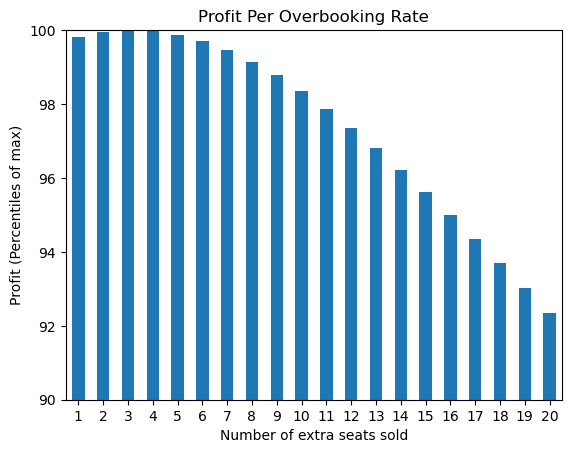

In [3]:
sim_data = overbooking_sim(20, 10000000, True)

In [11]:
sim_data.loc['profit']

0.004608    2153071314228.860107
0.009217    2155852716924.340088
0.013825         2157007986142.5
0.018433    2156523798350.160156
0.023041    2154392551037.900146
0.027650    2150631112643.540039
0.032258    2145356642143.740234
0.036866    2138644762012.160156
0.041475    2130614907036.060059
0.046083    2121405583548.960205
0.050691    2111168652033.580078
0.055300         2100030002737.0
0.059908     2088112624603.47998
0.064516    2075554925536.060059
0.069124    2062459787765.800293
0.073733    2048933192540.160156
0.078341         2035058273023.5
0.082949    2020907809676.320312
0.087558    2006469468643.260254
0.092166    1991937188426.540039
Name: profit, dtype: object

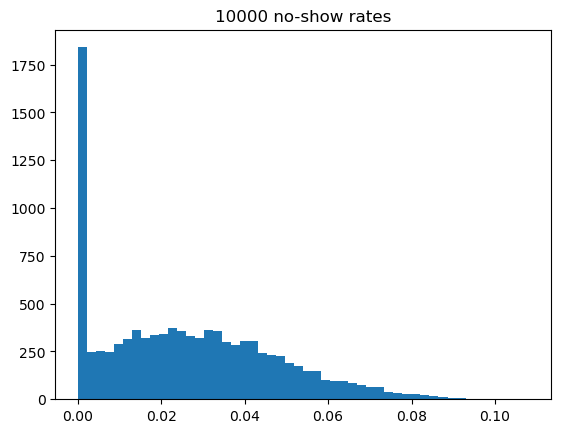

In [5]:
no_show_rates = gen_no_show_rates(10000, True)

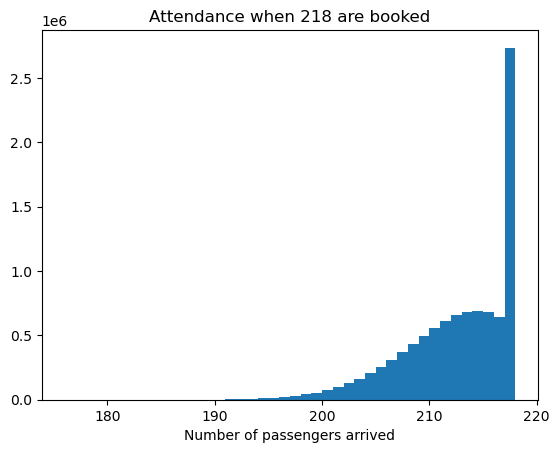

In [6]:
plane_attendance = sim_shows(no_show_rates, 218, 1000, True)

In [8]:
overflow_flights, total_bumps, bump_rate = calc_bump(plane_attendance, 218)
print(overflow_flights, total_bumps, bump_rate)

2140744 2140744.0 0.0009819926605504586


In [9]:
total_comp, empty_seats, opportunity_lost, capacity, profit = calc_profit(plane_attendance, total_bumps)
print(total_comp, empty_seats, opportunity_lost, capacity, profit)

3318153200.0 49434622.0 50272044496.68 0.9772 2153169602303.32
